In [1]:
import numpy as np
from keras.datasets import boston_housing
from keras import models
from keras import layers
from keras import losses
from keras import metrics
from keras import optimizers
import matplotlib.pyplot as plt

2023-10-04 10:55:23.431551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Load data
(trainData, trainTargets), (testData, testTargets) = boston_housing.load_data()

#Get a feel
trainData.shape


(404, 13)

In [3]:
#Normalize data
mean = trainData.mean(axis=0)
trainData -= mean
std = trainData.std(axis=0)
trainData /= std

testData -= mean
testData /= std

In [4]:
def buildModel():
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(trainData.shape[1],)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model


In [5]:
#Declare number of partitions 
k = 4

#numValSamples splits the training data into n partitions with floor division
#Evaluates to 101
numValSamples = len(trainData) // k

#However many you like
numEpochs = 100

#Empty list for scores
allScores = []

#Loop through each partition
for fold in range(k):
    print("processing fold #", fold)
    
    #Slice for each partition, i.e., (0 * numValSamples : 1 * numValSamples) evaluates as (0 : 101)
    #Second pass (1 * numValSamples : 2 * numValSamples) evaluates as (101 : 202) 
    #And so on
    valData = trainData[fold * numValSamples: (fold + 1) * numValSamples]
    
    #Repeat the same for our validation targets
    valTargets = trainTargets[fold * numValSamples: (fold + 1) * numValSamples]
    
    #Partition our validation data in much the same manner
    partialTrainData = np.concatenate(
        [trainData[:fold * numValSamples],
         trainData[(fold + 1) * numValSamples:]],
        axis = 0)
    partialTrainTargets = np.concatenate(
        [trainTargets[:fold * numValSamples],
         trainTargets[(fold + 1) * numValSamples:]],
        axis = 0)
    
    #Build, fit, evaluate model with mean absolute error appeneded to the empty scores list
    model = buildModel()
    history = model.fit(partialTrainData, partialTrainTargets, validation_data=(valData, valTargets), epochs = numEpochs, batch_size = 1, verbose = 0)
    maeHistory = history.history['val_mae']
    allScores.append(maeHistory)
    #valMse, valMae = model.evaluate(valData, valTargets, verbose = 0)
    #allScores.append(valMae)

#How much we're off by
np.mean(allScores)
    


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


2.5955067896842956

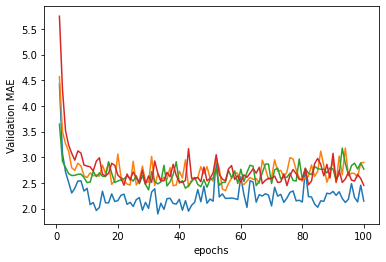

In [6]:
averageMaeHist = [([x[i] for x in allScores]) for i in range(numEpochs)]

plt.plot(range(1, len(averageMaeHist) + 1), averageMaeHist)
plt.xlabel('epochs')
plt.ylabel('Validation MAE')
plt.show()
